# Classify Handwritten Digits with Convolutional Neural Networks (CNNs)
By B Nord (2018 Nov 09)  
Minor updates by G Hosseinzadeh (2025 May 19)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import keras
from keras import layers

2025-05-23 14:39:03.234739: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Prepare the Data

### Download the data
Load the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) data set included in Keras. This consists of handwritten digits from 0-9 that we will try to identify with a CNN.

In [2]:
# uncomment the following line if the load_data function crashes with SSL: CERTIFICATE_VERIFY_FAILED
!curl https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz -o ~/.keras/datasets/mnist.npz

(x_train_temp, y_train_temp), (x_test_temp, y_test_temp) = keras.datasets.mnist.load_data()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.9M  100 10.9M    0     0  10.4M      0  0:00:01  0:00:01 --:--:-- 10.5M


### **Look** at the data
Check whether the shapes of 'data' and 'label' (for train and test, respectively) match. If they don't now, Keras/TF will kindly yell at you later. (You always do this so that you **know** what the structure is!)

In [3]:
print("Train Data Shape:",  np.shape(x_train_temp))
print("Test Data Shape:",  np.shape(x_test_temp))
print("Train Label Shape:",  np.shape(y_train_temp))
print("Test Label Shape:",  np.shape(y_test_temp))

Train Data Shape: (60000, 28, 28)
Test Data Shape: (10000, 28, 28)
Train Label Shape: (60000,)
Test Label Shape: (10000,)


Print out an example image and label from in the training set. Can you see the pattern of the number? Plot the first two images in the set.


5
0


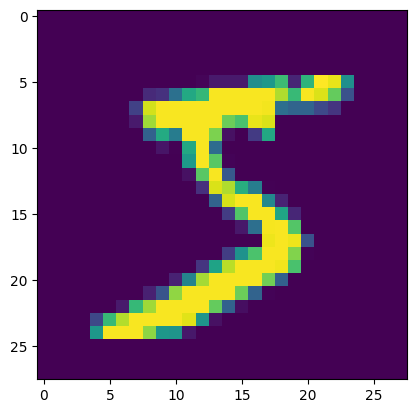

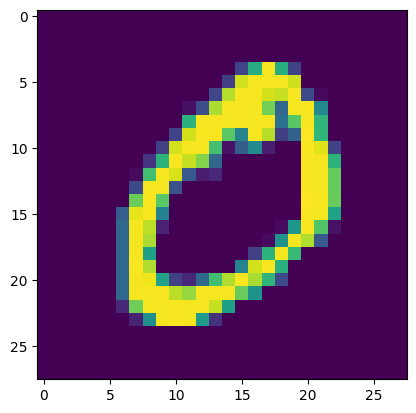

In [4]:
print(y_train_temp[0])
print(y_train_temp[1])

plt.imshow(x_train_temp[0])
plt.show()


plt.imshow(x_train_temp[1])
plt.show()


Data often need to be reshaped and normalized for ingestion into the neural network.
Add an extra (empty) dimension to the end of the images (see `np.expand_dims`).
Normalize the pixel values to be between 0 and 1 for the network.



In [5]:
x_train =  x_train_temp.astype("float32") / 255
x_test =  x_test_temp.astype("float32") / 255

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Apply *one-hot encoding* to the labels.


1.   The current encoding provides a literal label. For example, the label for "3"  is `3`.
2.   One-hot encoding places a "1" in an array at the appropriate location for that datum. For example, the label "3" becomes `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`.

This increases the efficiency of the matrix algebra during network training and evaluation.




In [6]:
num_classes = 10
input_shape = (28, 28, 1)

y_train = keras.utils.to_categorical(y_train_temp, num_classes)
y_test = keras.utils.to_categorical(y_test_temp, num_classes)

## Design Neural Network Architecture!

### Select model format and add layers to the model sequentially
Create a sequential model with the following layers:
1. input layer with the shape of one of the input images
2. 2D convolution layer with 32 filters, a kernel size of (3, 3), and a ReLU activation function
3. dropout layer with a rate of 0.25
4. flattening layer
5. fully connected (dense) layer with a neuron for each convolution filter and a ReLU activation function
6. dropout layer with a rate of 0.5
7. output fully connected (dense) layer with a neuron for each classification and a softmax activation function

Print out the model summary table.

In [7]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

### Compile the model

Select three key options
1.   **optimizer**: the method for optimizing the weights. "Stochastic Gradient Descent (SGD)" is the canonical method.
2.   **loss** function: the form of the function to encode the difference between the data's true label and the predict label.
3.   **metric**: the function by which the model is evaluated.

In [8]:
model.compile(loss="categorical_crossentropy", optimizer="SGD", metrics=["accuracy"])

### Fit (read: Train) the model
Use 5 epochs (batches) of 32 images and a validation split of 80%.

In [9]:
history = model.fit(x_train, y_train, batch_size=32, epochs=5, validation_split=0.8)

Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.3199 - loss: 2.0574 - val_accuracy: 0.8333 - val_loss: 0.6743
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.7848 - loss: 0.6841 - val_accuracy: 0.8942 - val_loss: 0.3720
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.8693 - loss: 0.4236 - val_accuracy: 0.9212 - val_loss: 0.2804
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.9014 - loss: 0.3321 - val_accuracy: 0.9324 - val_loss: 0.2358
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9169 - loss: 0.2866 - val_accuracy: 0.9409 - val_loss: 0.2058


## Diagnostics!


#### Evaluate overall model efficacy

Evaluate model on training and test data and compare. This provides summary values that are equivalent to the final value in the accuracy plot below.  Don't forget to undo the one-hot encoding for the predicted labels *(hint: `np.argmax`)*.

In [10]:
print(model.evaluate(x_train, y_train)) #probability
print(model.evaluate(x_test, y_test))

loss_train, acc_train = model.evaluate(x_train, y_train)

loss_test, acc_test = model.evaluate(x_test, y_test)

print(f'Train accuracy = {acc_train:.1%}')
print(f'Test accuracy = {acc_test:.1%}')
print(f'Train loss = {loss_train:.1%}')
print(f'Test loss = {loss_test:.1%}')

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9431 - loss: 0.2013
[0.20237889885902405, 0.9423999786376953]
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9370 - loss: 0.2151
[0.1863192617893219, 0.9474999904632568]
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9431 - loss: 0.2013
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9370 - loss: 0.2151
Train accuracy = 94.2%
Test accuracy = 94.7%
Train loss = 20.2%
Test loss = 18.6%


#### Plot accuracy and loss as a function of epochs (equivalently training time)
This information is stored in the `history` object you defined earlier.

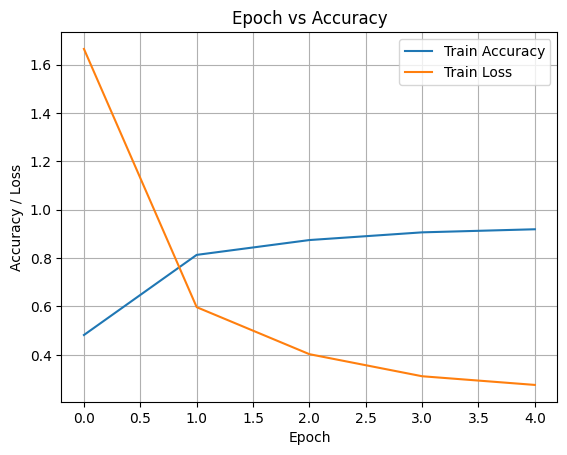

In [11]:
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.grid(True)
plt.legend()
plt.show()



#### Confusion Matrix
Plot a confusion matrix for the test data.

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
unnormalized
[[ 967    0    2    0    0    1    4    1    5    0]
 [   0 1113    3    2    0    0    4    0   13    0]
 [   7    2  939    9    9    4    7   26   27    2]
 [   1    1   12  952    0   19    0    8   14    3]
 [   1    2    3    0  937    0   10    3    3   23]
 [   5    1    1   15    1  854    8    2    4    1]
 [   9    3    2    1    6   18  918    0    1    0]
 [   1    9   31    6    2    1    0  965    5    8]
 [   8    0    5   13    3   11    5   12  909    8]
 [  11    7    5    9   12   10    1   22   11  921]]


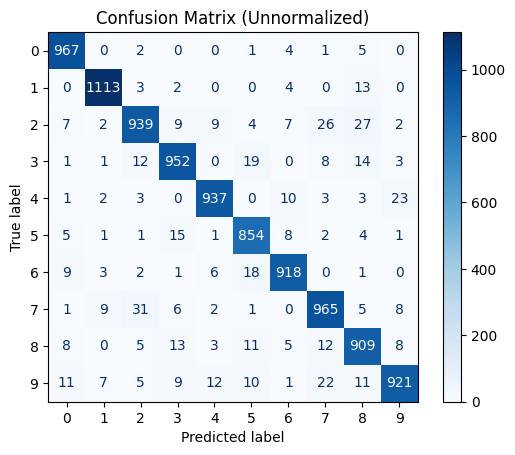

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


#confusion_matrix(y_true, y_pred)


# predict class probabilities on test data
y_pred_probs = model.predict(x_test)

#print(y_pred_probs)

# convert probabilities to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

#print(y_pred_classes)

cm = confusion_matrix(y_true_classes, y_pred_classes)


print("unnormalized")
print(cm)

display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(cmap='Blues')
plt.title("Confusion Matrix (Unnormalized)")
plt.show()
